## Library

In [144]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

#### seed 고정

In [145]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed = 42
seed_everything(seed)

## 미스라벨링

In [51]:
import os
from glob import glob
import pandas as pd
import shutil

def isFileChanged(file_path): # check if file changed based on last modified time 
    if os.path.getmtime(file_path) > 1614865992.0: 
        return True 

    return False

def correct_mask_status(data_dir, invalid_list, correct_list):
    print("="*50)
    print("Change Mask Status")

    for folder in invalid_list: 
        image_dir = os.path.join(data_dir, folder)

        incorrect_file = os.path.join(image_dir, correct_list[0])
        normal_file = os.path.join(image_dir, correct_list[1])

        if not isFileChanged(incorrect_file): #last modified time
            temp = os.path.join(image_dir, correct_list[2])

            os.rename(incorrect_file, temp)
            os.rename(normal_file, incorrect_file)
            os.rename(temp, normal_file)  # temp.jpg is not created in this folder

            print("Changed File Names")

        else :
            print("Already Changed")
    
    print("Process Done")



def change_incorrect_gender(incorrect, src, target): 
    changed_path = incorrect.replace(src, target)
    print(f"{incorrect.split('images/')[1]} is changing into {target}")
    shutil.move(incorrect, changed_path)


def correct_gender_status(data_dir, invalid_id_list): 
    df = pd.read_csv('/opt/ml/input/data/train/train.csv')

    path_list = [] # list that contains incorrect file path
    correct_gender_list = [] # list that contains correct gender of incorrect file path

    print("="*50)
    print("Change Gender Status")

    for path in df['path']:
        for pid in invalid_id_list:
            if pid in path:
                path_list.append(path)
                correct_gender_list.append("male" if "female" in path else "female")

    for idx, foldername in enumerate(path_list):
        folder_dir = os.path.join(data_dir, foldername)
        gender = correct_gender_list[idx]

        if gender == "male" and os.path.exists(folder_dir):
            change_incorrect_gender(folder_dir, "female", gender)

        elif gender=="female" and os.path.exists(folder_dir):
            change_incorrect_gender(folder_dir, "male", gender)

    print("Process Done")




def readCurrentFolders(data_dir): # change age task should read current folders
    return sorted(list(filter(lambda p:not p.startswith("."), os.listdir(data_dir))))    


def correct_age_status(data_dir, invalid_age_id):
    current_folders = readCurrentFolders(data_dir)
    idx = 0 # for age dict

    print("="*50)
    print("Change Age Status")

    for folder in current_folders: #sorted folders list
        invalid_path = os.path.join(data_dir, folder)
        invalid_age = folder.split("Asian_")[1]

        if folder.split("_")[0] in invalid_age_id.keys():
            correct_age = str(list(invalid_age_id.values())[idx])
            correct_path = invalid_path.replace(invalid_age, correct_age)

            print(f"{invalid_path.split('images/')[1]} is changing into {correct_path.split('images/')[1]}")
            shutil.move(invalid_path, correct_path)

            idx += 1


    print("Process Done")


if __name__ == "__main__":
    data_dir= "/opt/ml/input/data/train/images"

    mask_status_invalid = ["000020_female_Asian_50", "004418_male_Asian_20", "005227_male_Asian_22"]
    mask_status_name = ["incorrect_mask.jpg", "normal.jpg", "temp.jpg"]

    gender_status_invalid = ["000225", "000664", "000767", "001498-1", "001509", "003113", "003223", "004281", 
    "004432", "005223", "006359", "006360","006361", "006362", "006363", "006364", "006424"]

    age_status_invalid = {"001009" : 20, "001064": 20, "001637":20, "001666":20, "001852":20, "004348": 60}

    correct_mask_status(data_dir, mask_status_invalid, mask_status_name)
    correct_gender_status(data_dir, gender_status_invalid) 
    correct_age_status(data_dir, age_status_invalid)

Change Mask Status
Changed File Names
Already Changed
Already Changed
Process Done
Change Gender Status
000225_female_Asian_25 is changing into male
000664_female_Asian_55 is changing into male
000767_female_Asian_56 is changing into male
001498-1_male_Asian_23 is changing into female
001509_female_Asian_60 is changing into male
003113_female_Asian_20 is changing into male
003223_female_Asian_18 is changing into male
004281_female_Asian_60 is changing into male
004432_male_Asian_43 is changing into female
005223_male_Asian_22 is changing into female
006359_female_Asian_18 is changing into male
006360_female_Asian_18 is changing into male
006361_female_Asian_18 is changing into male
006362_female_Asian_18 is changing into male
006363_female_Asian_18 is changing into male
006364_female_Asian_18 is changing into male
006424_female_Asian_18 is changing into male
Process Done
Change Age Status
001009_female_Asian_40 is changing into 001009_female_Asian_20
001064_female_Asian_44 is changing 

## augmentation 

In [148]:
train_folder = '/opt/ml/input/data/train/images'
aug_path = '/opt/ml/input/data/train/augmentation'

for subdir in os.listdir(train_folder):
    # "."으로 시작하는 폴더면 건너뜀
    if subdir.startswith("."):
        continue

    # '_'기준으로 나누기
    # splitby = subdir.split('_')

    # 나이 60 이상인 것만 골라내기
    # split_age = int(splitby[3])
    # if split_age < 60:
    #     continue 
    
    subdir_path = os.path.join(train_folder, subdir)
    
    for file_name in os.listdir(subdir_path):
        # '.'로 시작하지 않는 이미지에 대해서 탐색
        if not file_name.startswith(".") and not file_name.startswith("mask"):
            image_path = os.path.join(subdir_path, file_name)
            
            img = Image.open(image_path)
            img = transforms.Compose([
                transforms.CenterCrop((256, 256)) # transform 기법
            ])(img)
            
            # 새로 이미지를 저장할 폴더
            new_dir = '1' + subdir
            new_folder = os.path.join(aug_path, new_dir)

            if os.path.isdir(new_folder) == False:
                os.mkdir(new_folder)
            
            img.save(os.path.join(new_folder, file_name))
            print(os.path.join(new_folder, file_name))


    

/opt/ml/input/data/train/augmentation/1006131_male_Asian_20/incorrect_mask.png
/opt/ml/input/data/train/augmentation/1006131_male_Asian_20/normal.png
/opt/ml/input/data/train/augmentation/1001546_male_Asian_26/normal.jpg
/opt/ml/input/data/train/augmentation/1001546_male_Asian_26/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/1004476_female_Asian_60/normal.jpg
/opt/ml/input/data/train/augmentation/1004476_female_Asian_60/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/1003051_female_Asian_20/normal.jpg
/opt/ml/input/data/train/augmentation/1003051_female_Asian_20/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/1003737_female_Asian_40/normal.jpg
/opt/ml/input/data/train/augmentation/1003737_female_Asian_40/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/1006708_male_Asian_19/normal.jpg
/opt/ml/input/data/train/augmentation/1006708_male_Asian_19/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/1000219_female_Asian_53/normal.jpg
/opt/ml/input/d

In [149]:
train_folder = '/opt/ml/input/data/train/images'
aug_path = '/opt/ml/input/data/train/augmentation'

for subdir in os.listdir(train_folder):
    # "."으로 시작하는 폴더면 건너뜀
    if subdir.startswith("."):
        continue

    # '_'기준으로 나누기
    splitby = subdir.split('_')

    # 나이 60 이상인 것만 골라내기
    split_age = int(splitby[3])
    if split_age < 60:
        continue 
    
    subdir_path = os.path.join(train_folder, subdir)
    
    for file_name in os.listdir(subdir_path):
        # '.'로 시작하지 않는 이미지에 대해서 탐색
        if not file_name.startswith("."):
            image_path = os.path.join(subdir_path, file_name)
            
            img = Image.open(image_path)
            img = transforms.Compose([
                transforms.ColorJitter(0.5, 0.5, 0.5, 0.5), # transform 기법
            ])(img)
            
            # 새로 이미지를 저장할 폴더
            new_dir = '2' + subdir
            new_folder = os.path.join(aug_path, new_dir)

            if os.path.isdir(new_folder) == False:
                os.mkdir(new_folder)
            
            img.save(os.path.join(new_folder, file_name))
            print(os.path.join(new_folder, file_name))

/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/mask5.jpg
/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/mask2.jpg
/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/normal.jpg
/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/mask3.jpg
/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/mask4.jpg
/opt/ml/input/data/train/augmentation/2004476_female_Asian_60/mask1.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian_60/mask5.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian_60/mask2.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian_60/normal.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian_60/mask3.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian_60/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian_60/mask4.jpg
/opt/ml/input/data/train/augmentation/2004236_male_Asian

In [150]:
train_folder = '/opt/ml/input/data/train/images'
aug_path = '/opt/ml/input/data/train/augmentation'

for subdir in os.listdir(train_folder):
    # "."으로 시작하는 폴더면 건너뜀
    if subdir.startswith("."):
        continue

    # '_'기준으로 나누기
    splitby = subdir.split('_')

    # 나이 60 이상인 것만 골라내기
    split_age = int(splitby[3])
    if split_age < 60:
        continue 
    
    subdir_path = os.path.join(train_folder, subdir)
    
    for file_name in os.listdir(subdir_path):
        # '.'로 시작하지 않는 이미지에 대해서 탐색
        if not file_name.startswith("."):
            image_path = os.path.join(subdir_path, file_name)
            
            img = Image.open(image_path)
            img = transforms.Compose([
                transforms.RandomRotation(10) # transform 기법
            ])(img)
            
            # 새로 이미지를 저장할 폴더
            new_dir = '3' + subdir
            new_folder = os.path.join(aug_path, new_dir)

            if os.path.isdir(new_folder) == False:
                os.mkdir(new_folder)
            
            img.save(os.path.join(new_folder, file_name))
            print(os.path.join(new_folder, file_name))

/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/mask5.jpg
/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/mask2.jpg
/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/normal.jpg
/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/mask3.jpg
/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/mask4.jpg
/opt/ml/input/data/train/augmentation/3004476_female_Asian_60/mask1.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian_60/mask5.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian_60/mask2.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian_60/normal.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian_60/mask3.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian_60/incorrect_mask.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian_60/mask4.jpg
/opt/ml/input/data/train/augmentation/3004236_male_Asian

## train_image.csv 만들기

In [151]:
# 이미지 별 클래스를 계산해주기 위한 dictionary
class_number = {
    'mask':0, 'inco':6, 'norm':12,
    'male':0, 'female':3 
    }

# 이미지 폴더들이 담긴 폴더 train_folder
train_folder = '/opt/ml/input/data/train/images'
aug_path = '/opt/ml/input/data/train/augmentation'

# augmentation 이미지도 탐색하기 위해 리스트로 담아줌
image_lst = [train_folder, aug_path]

# csv로 만들어주기 위한 리스트 image_names
image_names = []
for folder in image_lst:
    # if folder == aug_path:
    #     continue
    # train_folder의 폴더들 subdir별로 이미지 탐색 
    for subdir in os.listdir(folder):
        # "."으로 시작하는 폴더면 건너뜀
        if subdir.startswith("."):
            continue
        
        # subdir을 "_"로 split해서 클래스 이름별로 나누기
        name_class = subdir.split('_')
        # 이미지가 담긴 폴더의 클래스 label 먼저 계산(성별, 나이)
        folder_class = 0
        # 성별에 따른 숫자 더해줌
        folder_class += class_number[name_class[1]]
        
        # 나이는 30, 60 기준으로 나눠서 더해줌
        age = int(name_class[3]) 
        if age < 30:
            folder_class += 0
        elif 30 <= age < 60:
            folder_class += 1
        elif 60 <= age:
            folder_class += 2
        
        subdir_path = os.path.join(folder, subdir)

        # subdir 안의 이미지 탐색해서 이미지 별 클래스 계산
        for file_name in os.listdir(subdir_path):
            # '.'로 시작하지 않는 이미지에 대해서 탐색
            if not file_name.startswith("."):
                # image_class는 이미지 별 클래스 (마스크 여부에 따라 folder_class에 더해줌)
                image_class = folder_class + class_number[file_name[:4]]
                image_path = os.path.join(subdir_path, file_name)
                # image_names에 정보 담기
                image_names.append([name_class[0], name_class[1] , name_class[2], age, image_path, image_class])

print(os.listdir(aug_path)[:3])
print(image_names[:5])

['1005553_male_Asian_48', '1000010_female_Asian_58', '3004277_male_Asian_60']
[['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask2.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask3.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask5.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/mask1.png', 0], ['006131', 'male', 'Asian', 20, '/opt/ml/input/data/train/images/006131_male_Asian_20/incorrect_mask.png', 6]]


In [152]:
import csv

# image_names를 id 순으로 정렬
image_names.sort()
# 분류 기준 더해주기
image_names = [['id','gender','race','age','path', 'class']] + image_names

# train_image.csv 파일로 만들어서 저장
with open('train_image.csv', 'w') as file:
    write = csv.writer(file)
    write.writerows(image_names)


## train_image 분석

In [153]:
csv_path = "/opt/ml/code/train_image.csv"
train_image = pd.read_csv(csv_path)
# 무작위로 5개 뽑아보기
print(train_image.sample(5))

            id  gender   race  age  \
25743  3001444    male  Asian   60   
14558   005244    male  Asian   21   
3789    001173    male  Asian   30   
17182   006425  female  Asian   18   
13360   004428  female  Asian   56   

                                                    path  class  
25743  /opt/ml/input/data/train/augmentation/3001444_...      2  
14558  /opt/ml/input/data/train/images/005244_male_As...      0  
3789   /opt/ml/input/data/train/images/001173_male_As...      1  
17182  /opt/ml/input/data/train/images/006425_female_...      3  
13360  /opt/ml/input/data/train/images/004428_female_...      4  


In [154]:
print(train_image.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27002 entries, 0 to 27001
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      27002 non-null  object
 1   gender  27002 non-null  object
 2   race    27002 non-null  object
 3   age     27002 non-null  int64 
 4   path    27002 non-null  object
 5   class   27002 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB
None


In [155]:
print(train_image.describe(include='all'))

            id  gender   race           age  \
count    27002   27002  27002  27002.000000   
unique    5784       2      1           NaN   
top     003397  female  Asian           NaN   
freq        14   16321  27002           NaN   
mean       NaN     NaN    NaN     39.902155   
std        NaN     NaN    NaN     17.462572   
min        NaN     NaN    NaN     18.000000   
25%        NaN     NaN    NaN     20.000000   
50%        NaN     NaN    NaN     48.000000   
75%        NaN     NaN    NaN     57.000000   
max        NaN     NaN    NaN     60.000000   

                                                     path         class  
count                                               27002  27002.000000  
unique                                              27002           NaN  
top     /opt/ml/input/data/train/augmentation/3004230_...           NaN  
freq                                                    1           NaN  
mean                                                  NaN      6.

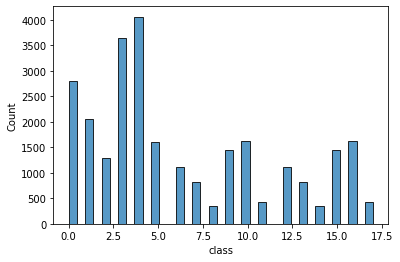

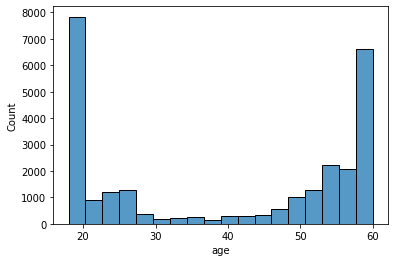

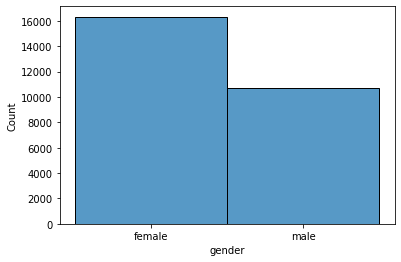

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# class 별 분포 살펴보기
sns.histplot(x='class',data=train_image,)
plt.show()

sns.histplot(x='age', data=train_image,)
plt.show()

sns.histplot(x='gender', data=train_image,)
plt.show()

#### 픽셀 별 평균, 표준편차 

In [119]:
import numpy as np

train_image = pd.read_csv(csv_path)

meanRGB = []
stdRGB = []

for p in list(train_image["path"]):
    i = Image.open(p)
    i = transforms.Compose([ToTensor()])(i)
    meanRGB.append(np.mean(i.numpy(), axis=(1,2)))
    stdRGB.append(np.std(i.numpy(), axis=(1,2)))

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.5572624 0.51909685 0.4957654
0.2301835 0.23817712 0.24158683


## Train Dataset

In [157]:
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        train_image = pd.read_csv(path) # dataframe으로 만들어주기
        self.image_paths = train_image["path"]
        self.image_labels = train_image["class"]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = None
        img = Image.open(self.image_paths[idx])
        label = torch.tensor(self.image_labels[idx])
        if self.transform is not None:
            img_transform = self.transform(img)
        return img_transform, label
        


In [170]:
t_dataset = CustomDataset(csv_path, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    Resize((384,384)),
    ToTensor(), 
    Normalize([0.5572, 0.5190, 0.4957],[0.2301, 0.2381, 0.2415])
    ]))
v_dataset = CustomDataset(csv_path, transform=transforms.Compose([
    Resize((384,384)),
    ToTensor(), 
    Normalize([0.5572, 0.5190, 0.4957],[0.2301, 0.2381, 0.2415])
    ]))

In [122]:
next(iter(t_dataset))

(tensor([[[ 1.0041,  1.0041,  1.0041,  ...,  0.8336,  0.8336,  0.8336],
          [ 1.0041,  1.0041,  1.0041,  ...,  0.8336,  0.8336,  0.8336],
          [ 1.0041,  1.0041,  1.0041,  ...,  0.8336,  0.8336,  0.8336],
          ...,
          [ 0.1178,  0.1178,  0.1178,  ...,  0.1690,  0.1690,  0.1519],
          [ 0.1690,  0.1690,  0.1690,  ...,  0.1008,  0.1008,  0.1008],
          [ 0.2030,  0.2030,  0.2030,  ...,  0.0326,  0.0326,  0.0326]],
 
         [[ 1.1143,  1.1143,  1.1143,  ...,  0.9496,  0.9496,  0.9496],
          [ 1.1143,  1.1143,  1.1143,  ...,  0.9496,  0.9496,  0.9496],
          [ 1.1143,  1.1143,  1.1143,  ...,  0.9496,  0.9496,  0.9496],
          ...,
          [-0.6151, -0.6316, -0.6316,  ..., -0.5327, -0.5327, -0.5492],
          [-0.6151, -0.6151, -0.6151,  ..., -0.5986, -0.5986, -0.5986],
          [-0.6316, -0.6316, -0.6316,  ..., -0.6645, -0.6645, -0.6645]],
 
         [[ 1.1139,  1.1139,  1.1139,  ...,  0.9515,  0.9515,  0.9515],
          [ 1.1139,  1.1139,

In [123]:
next(iter(v_dataset))

(tensor([[[ 0.8336,  0.8336,  0.8336,  ...,  1.0041,  1.0041,  1.0041],
          [ 0.8336,  0.8336,  0.8336,  ...,  1.0041,  1.0041,  1.0041],
          [ 0.8336,  0.8336,  0.8336,  ...,  1.0041,  1.0041,  1.0041],
          ...,
          [ 0.1519,  0.1690,  0.1690,  ...,  0.1178,  0.1178,  0.1178],
          [ 0.1008,  0.1008,  0.1008,  ...,  0.1690,  0.1690,  0.1690],
          [ 0.0326,  0.0326,  0.0326,  ...,  0.2030,  0.2030,  0.2030]],
 
         [[ 0.9496,  0.9496,  0.9496,  ...,  1.1143,  1.1143,  1.1143],
          [ 0.9496,  0.9496,  0.9496,  ...,  1.1143,  1.1143,  1.1143],
          [ 0.9496,  0.9496,  0.9496,  ...,  1.1143,  1.1143,  1.1143],
          ...,
          [-0.5492, -0.5327, -0.5327,  ..., -0.6316, -0.6316, -0.6151],
          [-0.5986, -0.5986, -0.5986,  ..., -0.6151, -0.6151, -0.6151],
          [-0.6645, -0.6645, -0.6645,  ..., -0.6316, -0.6316, -0.6316]],
 
         [[ 0.9515,  0.9515,  0.9515,  ...,  1.1139,  1.1139,  1.1139],
          [ 0.9515,  0.9515,

#### train, validation dataset 나누기

In [171]:
import random
from torch.utils.data import Subset

# dataset 두 개로 나누기
def split_index(length, val_ratio):
    n_val = int(length * val_ratio)
    val_indices = set(random.choices(range(length), k=n_val))
    train_indices = set(range((length))) - set(val_indices)
    return val_indices, train_indices

val_indices, train_indices = split_index(len(t_dataset), val_ratio=0.2)
train_dataset = Subset(t_dataset, list(train_indices))
val_dataset = Subset(v_dataset, list(val_indices))

print(len(train_dataset), len(val_dataset))

22124 4878


In [125]:
next(iter(train_dataset))

(tensor([[[ 1.0041,  1.0041,  1.0041,  ...,  0.8336,  0.8336,  0.8336],
          [ 1.0041,  1.0041,  1.0041,  ...,  0.8336,  0.8336,  0.8336],
          [ 1.0041,  1.0041,  1.0041,  ...,  0.8336,  0.8336,  0.8336],
          ...,
          [ 0.1178,  0.1178,  0.1178,  ...,  0.1690,  0.1690,  0.1519],
          [ 0.1690,  0.1690,  0.1690,  ...,  0.1008,  0.1008,  0.1008],
          [ 0.2030,  0.2030,  0.2030,  ...,  0.0326,  0.0326,  0.0326]],
 
         [[ 1.1143,  1.1143,  1.1143,  ...,  0.9496,  0.9496,  0.9496],
          [ 1.1143,  1.1143,  1.1143,  ...,  0.9496,  0.9496,  0.9496],
          [ 1.1143,  1.1143,  1.1143,  ...,  0.9496,  0.9496,  0.9496],
          ...,
          [-0.6151, -0.6316, -0.6316,  ..., -0.5327, -0.5327, -0.5492],
          [-0.6151, -0.6151, -0.6151,  ..., -0.5986, -0.5986, -0.5986],
          [-0.6316, -0.6316, -0.6316,  ..., -0.6645, -0.6645, -0.6645]],
 
         [[ 1.1139,  1.1139,  1.1139,  ...,  0.9515,  0.9515,  0.9515],
          [ 1.1139,  1.1139,

## Dataloader

In [172]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1)

In [127]:
next(iter(val_dataloader))

[tensor([[[[ 0.8507,  0.8507,  0.8507,  ...,  1.0552,  1.0552,  1.0552],
           [ 0.8507,  0.8507,  0.8507,  ...,  1.0552,  1.0552,  1.0552],
           [ 0.8507,  0.8507,  0.8507,  ...,  1.0382,  1.0382,  1.0382],
           ...,
           [-0.1719, -0.1889, -0.1889,  ...,  0.1349,  0.2201,  0.2542],
           [-0.3935, -0.4105, -0.4105,  ...,  0.1690,  0.2371,  0.2883],
           [-0.8366, -0.8366, -0.8366,  ...,  0.1690,  0.2542,  0.2883]],
 
          [[ 0.9661,  0.9661,  0.9661,  ...,  1.1637,  1.1637,  1.1637],
           [ 0.9661,  0.9661,  0.9661,  ...,  1.1637,  1.1637,  1.1637],
           [ 0.9661,  0.9661,  0.9661,  ...,  1.1472,  1.1472,  1.1472],
           ...,
           [-0.7798, -0.7963, -0.7963,  ..., -0.5327, -0.4998, -0.4668],
           [-0.9939, -1.0104, -1.0104,  ..., -0.4998, -0.4668, -0.4339],
           [-1.4221, -1.4221, -1.4221,  ..., -0.4998, -0.4504, -0.4174]],
 
          [[ 1.0165,  1.0165,  1.0165,  ...,  1.2113,  1.2113,  1.2113],
           [ 

## Model

In [173]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

device:[cuda:0].


In [174]:
from torchvision import models
model_resnet = models.resnet18(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 18)

In [83]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [175]:
import math

torch.nn.init.xavier_uniform_(model_resnet.fc.weight)
stdv = 1. / math.sqrt(model_resnet.fc.weight.size(1))
model_resnet.fc.bias.data.uniform_(-stdv, stdv)
print("네트워크 출력 채널 개수 (예측 class type 개수)", model_resnet.fc.weight.shape[0])

네트워크 출력 채널 개수 (예측 class type 개수) 18


## Loss

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )


class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=3, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


# https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

## Train 

In [176]:
model_resnet.to(device) 

LEARNING_RATE = 0.0001

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model_resnet.parameters(), lr=LEARNING_RATE) 


In [177]:
import numpy as np

loader_type = {
    "train": train_dataloader,
    "test": val_dataloader
}

NUM_EPOCH = 20
model_resnet.to(device)
best_test_acc = 0
best_test_loss = 9999.
patience = 0

for epoch in range(NUM_EPOCH):
    
    for mode in ["train", "test"]:
        running_loss = 0
        running_acc = 0
        
        if mode == 'train':
            model_resnet.train()
        elif mode == 'test':
            model_resnet.eval()
        
        for idx, (images, labels) in enumerate(loader_type[mode]):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(mode == 'train'):
                logits = model_resnet(images)
                _, preds = torch.max(logits, 1)
                loss = criterion(logits, labels)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(loader_type[mode].dataset)
        epoch_acc = running_acc / len(loader_type[mode].dataset)
        
        print(f'epoch: {epoch+1}, {mode}-데이터 셋 Loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')
        if mode == 'test' and best_test_acc < epoch_acc:
              best_test_acc = epoch_acc
        if mode == 'test' and best_test_loss > epoch_loss:
              best_test_loss = epoch_loss
        elif mode == 'test' and best_test_loss < epoch_loss:
            patience += 1
    
    if patience == 3:
        print('finished by early stopping!!')
        break
        
print("training end!!")
print(f"best acc: {best_test_acc}, best loss: {best_test_loss}")
    

epoch: 1, train-데이터 셋 Loss: 0.413, acc: 0.874
epoch: 1, test-데이터 셋 Loss: 0.189, acc: 0.933
epoch: 2, train-데이터 셋 Loss: 0.100, acc: 0.968
epoch: 2, test-데이터 셋 Loss: 0.177, acc: 0.935
epoch: 3, train-데이터 셋 Loss: 0.044, acc: 0.988
epoch: 3, test-데이터 셋 Loss: 0.093, acc: 0.970
epoch: 4, train-데이터 셋 Loss: 0.026, acc: 0.993
epoch: 4, test-데이터 셋 Loss: 0.086, acc: 0.975
epoch: 5, train-데이터 셋 Loss: 0.017, acc: 0.995
epoch: 5, test-데이터 셋 Loss: 0.055, acc: 0.982
epoch: 6, train-데이터 셋 Loss: 0.018, acc: 0.995
epoch: 6, test-데이터 셋 Loss: 0.051, acc: 0.985
epoch: 7, train-데이터 셋 Loss: 0.019, acc: 0.994
epoch: 7, test-데이터 셋 Loss: 0.139, acc: 0.957
epoch: 8, train-데이터 셋 Loss: 0.021, acc: 0.993
epoch: 8, test-데이터 셋 Loss: 0.072, acc: 0.980
epoch: 9, train-데이터 셋 Loss: 0.014, acc: 0.996
epoch: 9, test-데이터 셋 Loss: 0.058, acc: 0.984
finished by early stopping!!
training end!!
best acc: 0.9846248626708984, best loss: 0.05129142164402764


## Test Dataset & Dataloader

In [178]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [179]:
test_dir = '/opt/ml/input/data/eval'

submission8 = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

image_paths = [os.path.join(image_dir, img_id) for img_id in submission8.ImageID]

test_dataset = TestDataset(image_paths, transform=transforms.Compose([
    ToTensor(), 
    Normalize([0.5572, 0.5190, 0.4957],[0.2301, 0.2381, 0.2415])
    ]))
test_loader = DataLoader(test_dataset,shuffle=False)


## Test

In [180]:
model_resnet.eval()

all_predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model_resnet(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission8['ans'] = all_predictions

submission8.to_csv(os.path.join(test_dir, 'submission8.csv'), index=False)
print('test inference is done!')

test inference is done!
